In [1]:
import os
import ast
import random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from datasets import load_dataset, DatasetDict, Sequence, ClassLabel, Dataset
from transformers import (
    AutoTokenizer,
    AutoModelForTokenClassification,
    TrainingArguments,
    Trainer,
    DataCollatorForTokenClassification,
)
from seqeval.metrics import classification_report, precision_score, recall_score, f1_score
from torch import cuda

# Setup device
device = 'cuda' if cuda.is_available() else 'cpu'
print(f"Running on device: {device}")

c:\Users\Seed\anaconda3\envs\travel_order\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm



Running on device: cuda


In [2]:
# Labels
label_list = ["O", "B-DEP", "I-DEP", "B-ARR", "I-ARR"]

# Load Dataset
path = r"C:\Users\Seed\Projects\Travel-Order-Resolver\ai\nlp\dataset\tokens\token.csv"
dataset = load_dataset('csv', data_files={'train': path}, delimiter=';')
dataset["train"] = dataset["train"].remove_columns("spacy_ner_tags")

In [3]:
# Validate and filter data
def is_valid_row(row):
    try:
        tokens = ast.literal_eval(row['tokens'])
        ner_tags = ast.literal_eval(row['ner_tags'])
        return (
            isinstance(tokens, list) and all(isinstance(t, str) for t in tokens)
            and isinstance(ner_tags, list) and all(isinstance(tag, int) for tag in ner_tags)
        )
    except (ValueError, SyntaxError):
        return False

dataset = dataset.filter(is_valid_row)
dataset = dataset.map(lambda line: {'tokens': ast.literal_eval(line['tokens']), 'ner_tags': ast.literal_eval(line['ner_tags'])})
dataset = dataset.cast_column("ner_tags", Sequence(feature=ClassLabel(num_classes=len(label_list), names=label_list)))

In [4]:
# Shuffle and split dataset
train_data = dataset['train'].shuffle(seed=42).train_test_split(test_size=0.7)['train']
train_test_valid = train_data.train_test_split(test_size=0.25)
test_valid = train_test_valid['test'].train_test_split(test_size=0.7)
dataset = DatasetDict({
    'train': train_test_valid['train'],
    'test': test_valid['test'],
    'valid': test_valid['train'],
})

# Initialize tokenizer and model
model_checkpoint = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

In [5]:
def tokenize_and_align_labels(examples):
    tokenized_inputs = tokenizer(examples["tokens"], truncation=True, padding=True, is_split_into_words=True)
    labels = []
    for i, label in enumerate(examples["ner_tags"]):
        word_ids = tokenized_inputs.word_ids(batch_index=i)
        previous_word_idx = None
        label_ids = []
        for word_idx in word_ids:
            if word_idx is None:
                label_ids.append(-100)
            elif word_idx != previous_word_idx:
                label_ids.append(label[word_idx])
            else:
                label_ids.append(-100)
            previous_word_idx = word_idx
        labels.append(label_ids)
    tokenized_inputs["labels"] = labels
    return tokenized_inputs

dataset = dataset.map(tokenize_and_align_labels, batched=True)

# Prepare model
id2label = {i: label for i, label in enumerate(label_list)}
label2id = {label: i for i, label in id2label.items()}

model = AutoModelForTokenClassification.from_pretrained(
    model_checkpoint,
    num_labels=len(label_list),
    id2label=id2label,
    label2id=label2id,
)


Map: 100%|██████████| 9810/9810 [00:00<00:00, 14045.57 examples/s]
Some weights of DistilBertForTokenClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [6]:

from transformers.tokenization_utils_base import BatchEncoding

def batch_encoding_to(self, device, non_blocking=False):
    # Move all tensors in BatchEncoding to the specified device
    for key, value in self.items():
        if hasattr(value, "to"):  # Check if the value supports .to()
            self[key] = value.to(device, non_blocking=non_blocking)
    return self

BatchEncoding.to = batch_encoding_to


# Clear GPU cache
import torch
torch.cuda.empty_cache()

# Training arguments
batch_size = 4
epochs = 3
training_args = TrainingArguments(
    output_dir=r"C:\Users\Seed\Projects\Travel-Order-Resolver\ai\nlp\models\tokens_classification\distilbert",
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=epochs,
    weight_decay=0.01,
    gradient_accumulation_steps=2, # Accumulate gradients over 2 steps
    fp16=True,  # Enable mixed precision
)

# Data collator and Trainer
data_collator = DataCollatorForTokenClassification(tokenizer)

c:\Users\Seed\anaconda3\envs\travel_order\Lib\site-packages\transformers\training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [7]:
from sklearn.metrics import accuracy_score

def compute_metrics(p):
    predictions, labels = p
    predictions = np.argmax(predictions, axis=2)
    y_pred = [[label_list[p] for p, l in zip(pred, lab) if l != -100] for pred, lab in zip(predictions, labels)]
    y_true = [[label_list[l] for p, l in zip(pred, lab) if l != -100] for pred, lab in zip(predictions, labels)]
    
    # Compute classification report
    results = classification_report(y_true, y_pred, output_dict=True)
    
    # Compute accuracy separately
    flat_y_true = [label for sublist in y_true for label in sublist]
    flat_y_pred = [label for sublist in y_pred for label in sublist]
    accuracy = accuracy_score(flat_y_true, flat_y_pred)
    
    return {
        "precision": results["macro avg"]["precision"],
        "recall": results["macro avg"]["recall"],
        "f1": results["macro avg"]["f1-score"],
        "accuracy": accuracy,  # Use computed accuracy
    }

trainer = Trainer(
    model,
    training_args,
    train_dataset=dataset["train"],
    eval_dataset=dataset["valid"],
    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

# Train and evaluate
trainer.train()
trainer.save_model(r"C:\Users\Seed\Projects\Travel-Order-Resolver\ai\nlp\models\tokens_classification\distilbert")
train_metrics = trainer.evaluate(dataset["train"])
validation_metrics = trainer.evaluate(dataset["valid"])

C:\Users\Seed\AppData\Local\Temp\ipykernel_29664\3077483934.py:24: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,0.000800,0.000700,0.999039,0.999547,0.999293,0.999883
2,0.000200,0.000623,0.999774,0.999887,0.999830,0.999949


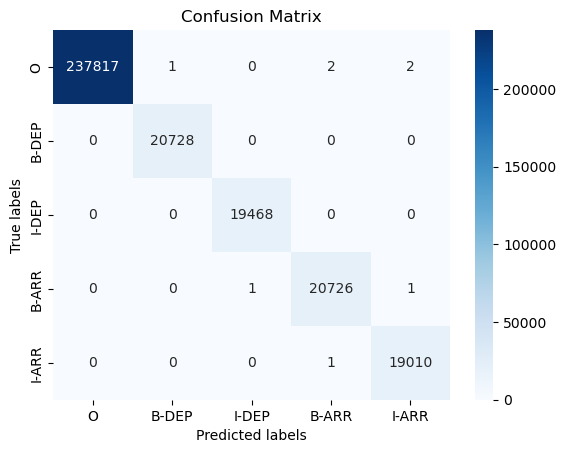

In [8]:
from sklearn.metrics import confusion_matrix

# Test predictions
predictions, labels, _ = trainer.predict(dataset["test"])
predictions = np.argmax(predictions, axis=2)

y_pred = [[label_list[p] for p, l in zip(pred, lab) if l != -100] for pred, lab in zip(predictions, labels)]
y_true = [[label_list[l] for p, l in zip(pred, lab) if l != -100] for pred, lab in zip(predictions, labels)]

# Confusion Matrix
flat_y_true = [item for sublist in y_true for item in sublist]
flat_y_pred = [item for sublist in y_pred for item in sublist]

cm = confusion_matrix(flat_y_true, flat_y_pred, labels=label_list)
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', xticklabels=label_list, yticklabels=label_list)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()